In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

# Visualize
import seaborn as sns
import matplotlib.pyplot as plt

# Metrics
from sklearn.metrics import multilabel_confusion_matrix

# Myutils
from modules.get_data_function import get_dataset

2022-08-10 07:46:17.388302: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# =========== Declare Variable ==============
STRATEGY = tf.distribute.get_strategy()    
BATCH_SIZE = 16
IMG_SIZE = 224
SEED = 42
input_path = "dataset/ChestXray NIH"


# =========================== Functions =====================================
def main():
    test_filenames = tf.io.gfile.glob(f'{input_path}/data/224x224/test/*.tfrec')
    test_dataset = get_dataset(test_filenames)
    
    tf.keras.backend.clear_session()
    model = tf.keras.models.load_model(f"/home/jovyan/ChestXray-14/results/models/Resnet50_epochs-20.h5")
    preds = model.predict(test_dataset)
    print(preds)
    
    return test_dataset, preds


# ============ Run Main Program =============
if tf.test.gpu_device_name():
    """
    Check if a GPU is none it's will terminate programs.
    """
    test_dataset, preds = main()
else:
    print("\n===== Please, install GPU =====")
# ===========================================

2022-08-10 07:46:20.383303: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-10 07:46:21.232758: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /device:GPU:0 with 8011 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 2g.10gb, pci bus id: 0000:17:00.0, compute capability: 8.0
2022-08-10 07:46:21.287852: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8011 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 2g.10gb, pci bus id: 0000:17:00.0, compute capability: 8.0
2022-08-10 07:46:26.813193: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201
2022-08-10 07:46:27.

      7/Unknown - 5s 31ms/step

2022-08-10 07:46:29.245677: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


700/700 [==============================] - 27s 32ms/step
[[6.5012467e-01 4.8834119e-02 2.4356164e-02 ... 4.1446771e-02
  4.8786987e-02 2.1746310e-03]
 [3.2958460e-01 1.8576491e-01 1.3243873e-01 ... 4.6839975e-02
  5.4189105e-02 9.3676953e-04]
 [2.2559632e-01 2.2842360e-01 2.0745215e-01 ... 2.0029103e-02
  2.9370606e-02 1.1589535e-04]
 ...
 [7.7393824e-01 2.8737141e-02 5.9537697e-03 ... 3.3177078e-02
  2.0062646e-02 2.9612530e-03]
 [2.5232893e-01 1.9173194e-01 2.0306845e-01 ... 2.2736503e-02
  3.1068336e-02 4.8490037e-04]
 [2.2361951e-01 6.6016868e-02 1.6290361e-01 ... 3.5048943e-02
  5.4418180e-02 1.1108981e-04]]


In [3]:
# def get_label_from_test_dataset(dataset):
#     tmp = []
#     for data in dataset:
#         labels = data[1]
#         for label in labels:
#             tmp.append(label.numpy())
#     return tmp

In [3]:

def get_label_from_test_dataset(dataset):
    for data in dataset:
        labels = data[1]
        for label in labels:
            yield label.numpy().tolist()
            
test_dataset_all = get_label_from_test_dataset(test_dataset)

y_true = np.array(list(test_dataset_all))
y_true[:5]

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [4]:
y_preds = (preds > 0.5).astype("int8")
y_preds

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

In [5]:
y_true

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [7]:
# import pickle

# with open("/home/jovyan/ChestXray-14/y_true.pk", "wb") as file:
#     pickle.dump(y_true, file)

# tmp_ = pickle.load(open("/home/jovyan/ChestXray-14/y_true.pk", "rb"))
# print(tmp_)

In [8]:
# def my_confusion_metrics:
#     pass

# def my_multi_label_cunfusion_metrics(y_trues, y_preds):
#     tmp = tf.zeros(shape=(15,15),
#                    dtype="int32")
#     for y_true, y_pred, _index in zip(y_trues, y_preds, range(2)):
#         tmp = tmp + tf.math.confusion_matrix(y_true, y_pred, num_classes=15)
#         # break
#     return tmp


# confusion_metrics = my_multi_label_cunfusion_metrics(y_true, y_preds)

In [6]:
y_true.shape

(11200, 15)

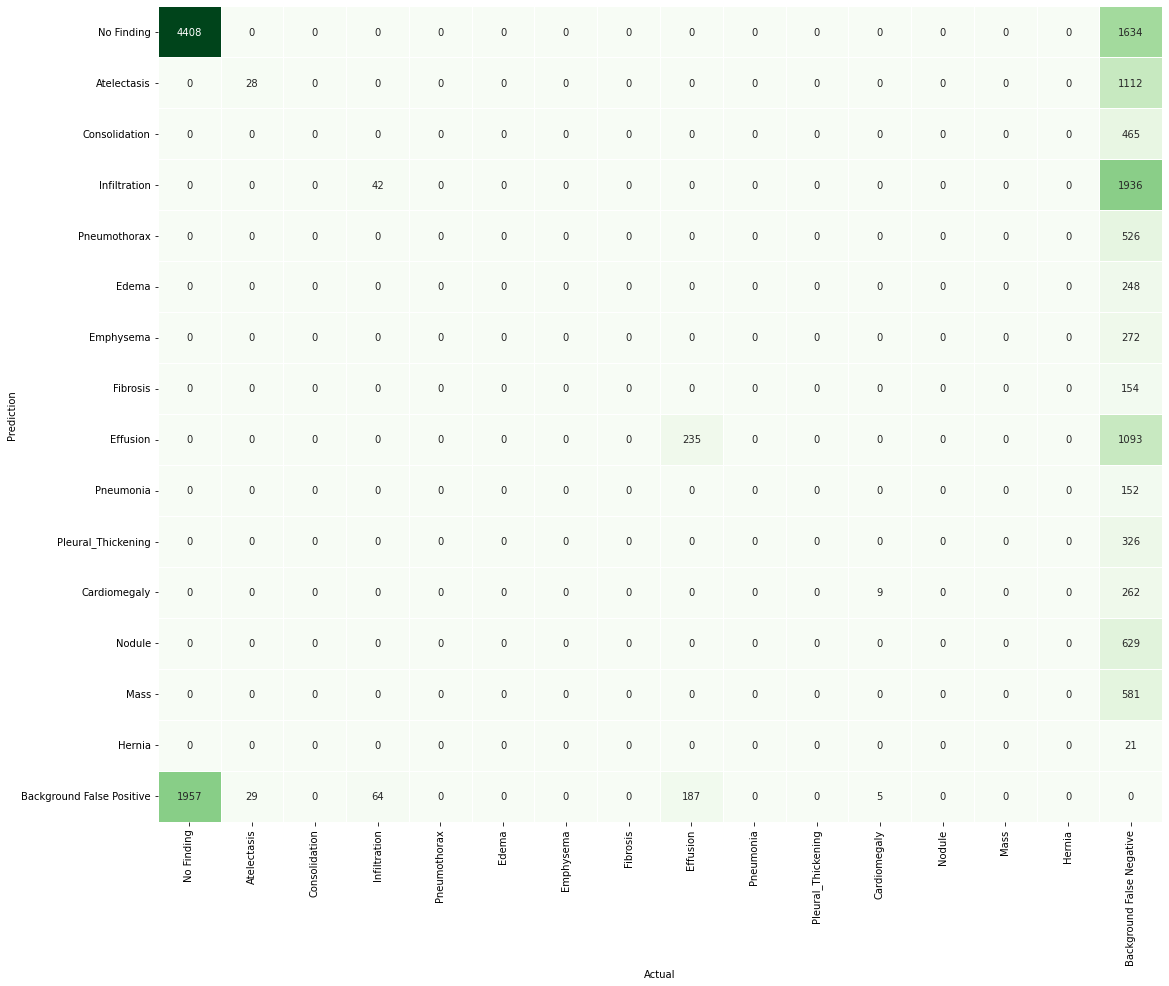

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

class ConfusionMetrics:
    def __init__(self):
        self.col_names = ['No Finding', 'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia']
        self.counts = 0
    
    def fit(self, y_trues, y_preds):
        confusion_metrics = np.zeros(shape=(y_trues.shape[-1]+1, 
                                            y_preds.shape[-1]+1))
        for y_true, y_pred in zip(y_trues, y_preds):
            # print("==== Round {} ====".format(self.counts))
            # print("Actual :", y_true)
            # print("Predict:", y_pred)
            for (idx, (element_true, element_pred)) in enumerate(zip(y_true, y_pred)):
                # True Positive
                if element_true == element_pred and element_true == 1: 
                    confusion_metrics[idx, idx] = confusion_metrics[idx, idx] + 1
                
                # False Negative
                elif element_true != element_pred and element_true == 1: 
                    col_idx = 15
                    confusion_metrics[idx, col_idx] = confusion_metrics[idx, col_idx] + 1
                    
                # False Positive
                elif element_true != element_pred and element_true == 0:
                    row_idx = 15
                    confusion_metrics[row_idx, idx] = confusion_metrics[row_idx, idx] + 1
            
            # if self.counts == 5:
            #     break
                
            self.counts = self.counts + 1
        return confusion_metrics, self.col_names

confusion_metrics, col_names = ConfusionMetrics().fit(y_true, y_preds)
plt.figure(figsize=(18, 15))
confusion_metrics_plot =  sns.heatmap(confusion_metrics,
                                      cmap="Greens",
                                      annot=True,
                                      label=True,
                                      fmt=".10g",
                                      cbar=False,
                                      linewidths=.5,
                                      xticklabels=col_names + ["Background False Negative"],
                                      yticklabels=col_names + ["Background False Positive"])
plt.ylabel("Prediction")
plt.xlabel("Actual")
fig = confusion_metrics_plot.get_figure()
fig.savefig("Multi_Label_Confusion_Metrics_Resnet50.png") 
plt.show();

# --- Break ---

In [8]:
""" Columns Names for ChestXray NIH
col_names = ['No Finding', 'Atelectasis', 'Consolidation', 'Infiltration',
   'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion',
   'Pneumonia', 'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass',
   'Hernia']
""";
